# Exercise 4: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [1]:
#### Load libraries
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

In [2]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

path_data = 'data/'
s_selection = np.load(path_data+'s_selection.npy')
cuts = {'ee_s' : {'Pcharged':(0,200), 'Ncharged':(0,7),'E_ecal':(65,200),'E_hcal':(0,5),'cos_thet': (-0.9,s_selection[0])}, 
         'mm' : {'Pcharged':(75,200), 'Ncharged':(1,7),'E_ecal':(0,27),'E_hcal':(0,40)}, 
         'qq' : {'Pcharged':(0,200), 'Ncharged':(7,200),'E_ecal':(27,90),'E_hcal':(0,100)},
         'tt' : {'Pcharged':(0,75), 'Ncharged':(2,7),'E_ecal':(0,65),'E_hcal':(0,50)}}

In [3]:
# test if x is element of interval I
def isin(x,I):
    if x >= I[0] and x < I[1]: return True
    else: return False

# categorize the events: put array indices of measured data into the corresponding energy category
# return dictionary with indices
def cat_energy(E_Lep,en_edges):
    energy_indices={'energy_1':[] ,'energy_2':[] ,'energy_3':[] ,'energy_4':[] ,'energy_5':[] , 'energy_6':[],
                    'energy_7':[]}
    
    i=0;
    for e in 2*E_Lep:
        if e<en_edges[1]:
            energy_indices['energy_1'].append(i)
        elif e>=en_edges[1] and e<en_edges[2]:
            energy_indices['energy_2'].append(i)
        elif e>=en_edges[2] and e<en_edges[3]:
            energy_indices['energy_3'].append(i)
        elif e>=en_edges[3] and e<en_edges[4]:
            energy_indices['energy_4'].append(i)
        elif e>=en_edges[4] and e<en_edges[5]:
            energy_indices['energy_5'].append(i)
        elif e>=en_edges[5] and e<en_edges[6]:
            energy_indices['energy_6'].append(i)
        elif e>=en_edges[6]:
            energy_indices['energy_7'].append(i)
        i+=1;
    
    return energy_indices

# Function to obtain the cos_thet_muon numpy array from the opal data
def get_cos_theta_muon(en_indices,cuts,Pchar,Nchar,E_ecal,E_hcal,cos_thet):
    cos_theta_muon={'energy_1':[] ,'energy_2':[] ,'energy_3':[] ,'energy_4':[] ,'energy_5':[] , 'energy_6':[],
                    'energy_7':[]}
    
    measurements = {'Pcharged': Pchar, 'Ncharged': Nchar,'E_ecal': E_ecal,'E_hcal': E_hcal, 'cos_thet': cos_thet}
    for energy, indices in en_indices.items():
        for i in indices:
            for var, interval in cuts['mm'].items():
                is_channel = True;
                if not isin(measurements[var][i],interval):
                    is_channel = False;
                if is_channel:
                    cos_theta_muon[energy].append(measurements['cos_thet'][i])
                    continue;
        
    
    return cos_theta_muon

### Mote Carlo data:

In [4]:
### Read in data
mc_data_mm = uproot.open(path_data+'mm.root')
ttree_name = 'myTTree'
branches_mm = mc_data_mm[ttree_name].arrays()


# What is the mean energy ?
print(f"mean energy: {np.mean(ak.to_numpy(branches_mm['E_lep'])*2)} GeV")

mean energy: 91.24799346923828 GeV


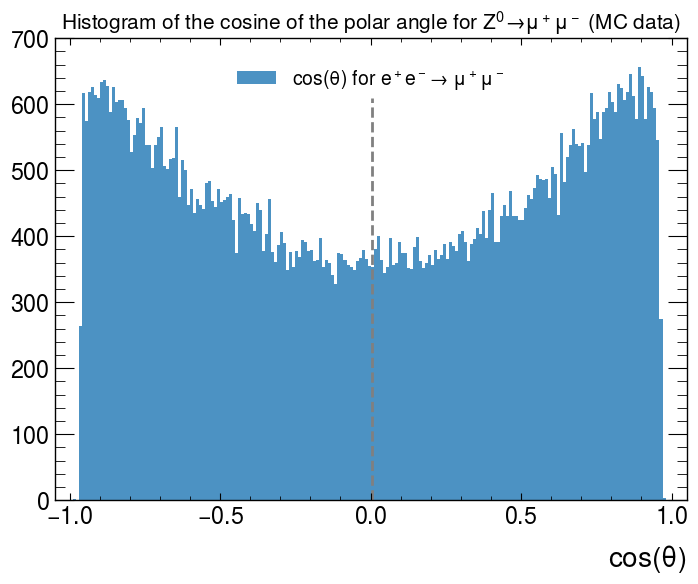

In [5]:
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
plt.title(r'Histogram of the cosine of the polar angle for $Z^0 \to \mu^+\mu^-$ (MC data)',fontsize=15)
hbins, hedges, _ = plt.hist(ak.to_numpy(branches_mm['cos_thet']),bins= 200, range=(-1,1),
         label=r'$\cos(\theta)$ for $e^+e^- \to \ \mu^+\mu^-$', alpha = 0.8)

h_mids = 0.5 * (hedges[1:] + hedges[:-1])

          
c=100
plt.axvline(h_mids[c],ymax=0.87,linestyle = '--',color='grey')


plt.xlim(-1.05,1.05)
plt.xlabel(r'$\cos(\theta)$')
plt.legend()
plt.show()

In [6]:
# count muons on left (backward) and right (forward) side
counter_back = sum(hbins[:c]) 
counter_forw = sum(hbins[c:]) 

# calculate the forward-backward asymmetry factor
A_FB = (counter_forw-counter_back)/(counter_forw+counter_back) +radiation_corrections['correction'][3]
# error via error propagation
A_FB_sigma= np.sqrt(counter_forw/(counter_forw+counter_back)**2+ 
                    ((counter_forw-counter_back)/(counter_forw+counter_back)**2)**2*counter_forw+
                      counter_back/(counter_forw+counter_back)**2+ 
                      ((counter_forw-counter_back)/(counter_forw+counter_back)**2)**2*counter_back)

sin_thet_sq=1/4*(1-np.sqrt(A_FB/3)) #approximation used since mean energy close to resonance energy

sin_thet_sq_sigma=1/8/np.sqrt(A_FB/3)*1/3*np.sqrt(A_FB_sigma) 

print(f'sin^2(theta_W)=(%.2f \pm %.2f)' % (sin_thet_sq,sin_thet_sq_sigma))

sin^2(theta_W)=(0.23 \pm 0.03)


### Opal data:

In [7]:
### Load information from the csv file
rows = []
with open(path_data+'daten_3.csv','r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append(row)
mean_energy_opal=np.array(list(zip(*rows[1:]))[0], dtype=float)
lumi=np.array(list(zip(*rows[1:]))[1], dtype=float)
stat=np.array(list(zip(*rows[1:]))[2], dtype=float)
sys=np.array(list(zip(*rows[1:]))[3], dtype=float)
sq_sum=np.array(list(zip(*rows[1:]))[4], dtype=float)

lum_data = {'energy_1': {'lumi': lumi[0] ,'stat': stat[0] , 'sys': sys[0],'all': sq_sum[0]},
            'energy_2': {'lumi': lumi[1] ,'stat': stat[1] , 'sys': sys[1],'all': sq_sum[1]},
            'energy_3': {'lumi': lumi[2] ,'stat': stat[2] , 'sys': sys[2],'all': sq_sum[2]},
            'energy_4': {'lumi': lumi[3] ,'stat': stat[3] , 'sys': sys[3],'all': sq_sum[3]},
            'energy_5': {'lumi': lumi[4] ,'stat': stat[4] , 'sys': sys[4],'all': sq_sum[4]},
            'energy_6': {'lumi': lumi[5] ,'stat': stat[5] , 'sys': sys[5],'all': sq_sum[5]},
            'energy_7': {'lumi': lumi[6] ,'stat': stat[6] , 'sys': sys[6],'all': sq_sum[6]}}


### Load opal data, Store measurements in numpy arrays
opal_data = uproot.open(path_data+'daten_3.root')
ttree_name = 'myTTree'
branches_opal = opal_data[ttree_name].arrays()
Nchar = ak.to_numpy(branches_opal['Ncharged'])
Pchar = ak.to_numpy(branches_opal['Pcharged'])
E_Ecal = ak.to_numpy(branches_opal['E_ecal'])
E_Hcal = ak.to_numpy(branches_opal['E_hcal'])
E_Lep = ak.to_numpy(branches_opal['E_lep'])
cos_thet = ak.to_numpy(branches_opal['cos_thet'])

In [8]:
# Simulare to ex3: Categorize the data after their energy
en_edges=[min(2*E_Lep)]
for i in range(6):
    en_edges.append((mean_energy_opal[i]+mean_energy_opal[i+1])/2)
    
en_edges.append(max(2*E_Lep))
energy_indices = cat_energy(E_Lep,en_edges)

# Get the cos_theta measurements of the muon channel
cos_theta_muon = get_cos_theta_muon(energy_indices,cuts,Pchar,Nchar,E_Ecal,E_Hcal,cos_thet)

In [9]:
for energy, cm in cos_theta_muon.items():
    print(f"{energy}: {len(cm)} entries")

energy_1: 5499 entries
energy_2: 11282 entries
energy_3: 17267 entries
energy_4: 101684 entries
energy_5: 19161 entries
energy_6: 8200 entries
energy_7: 11402 entries


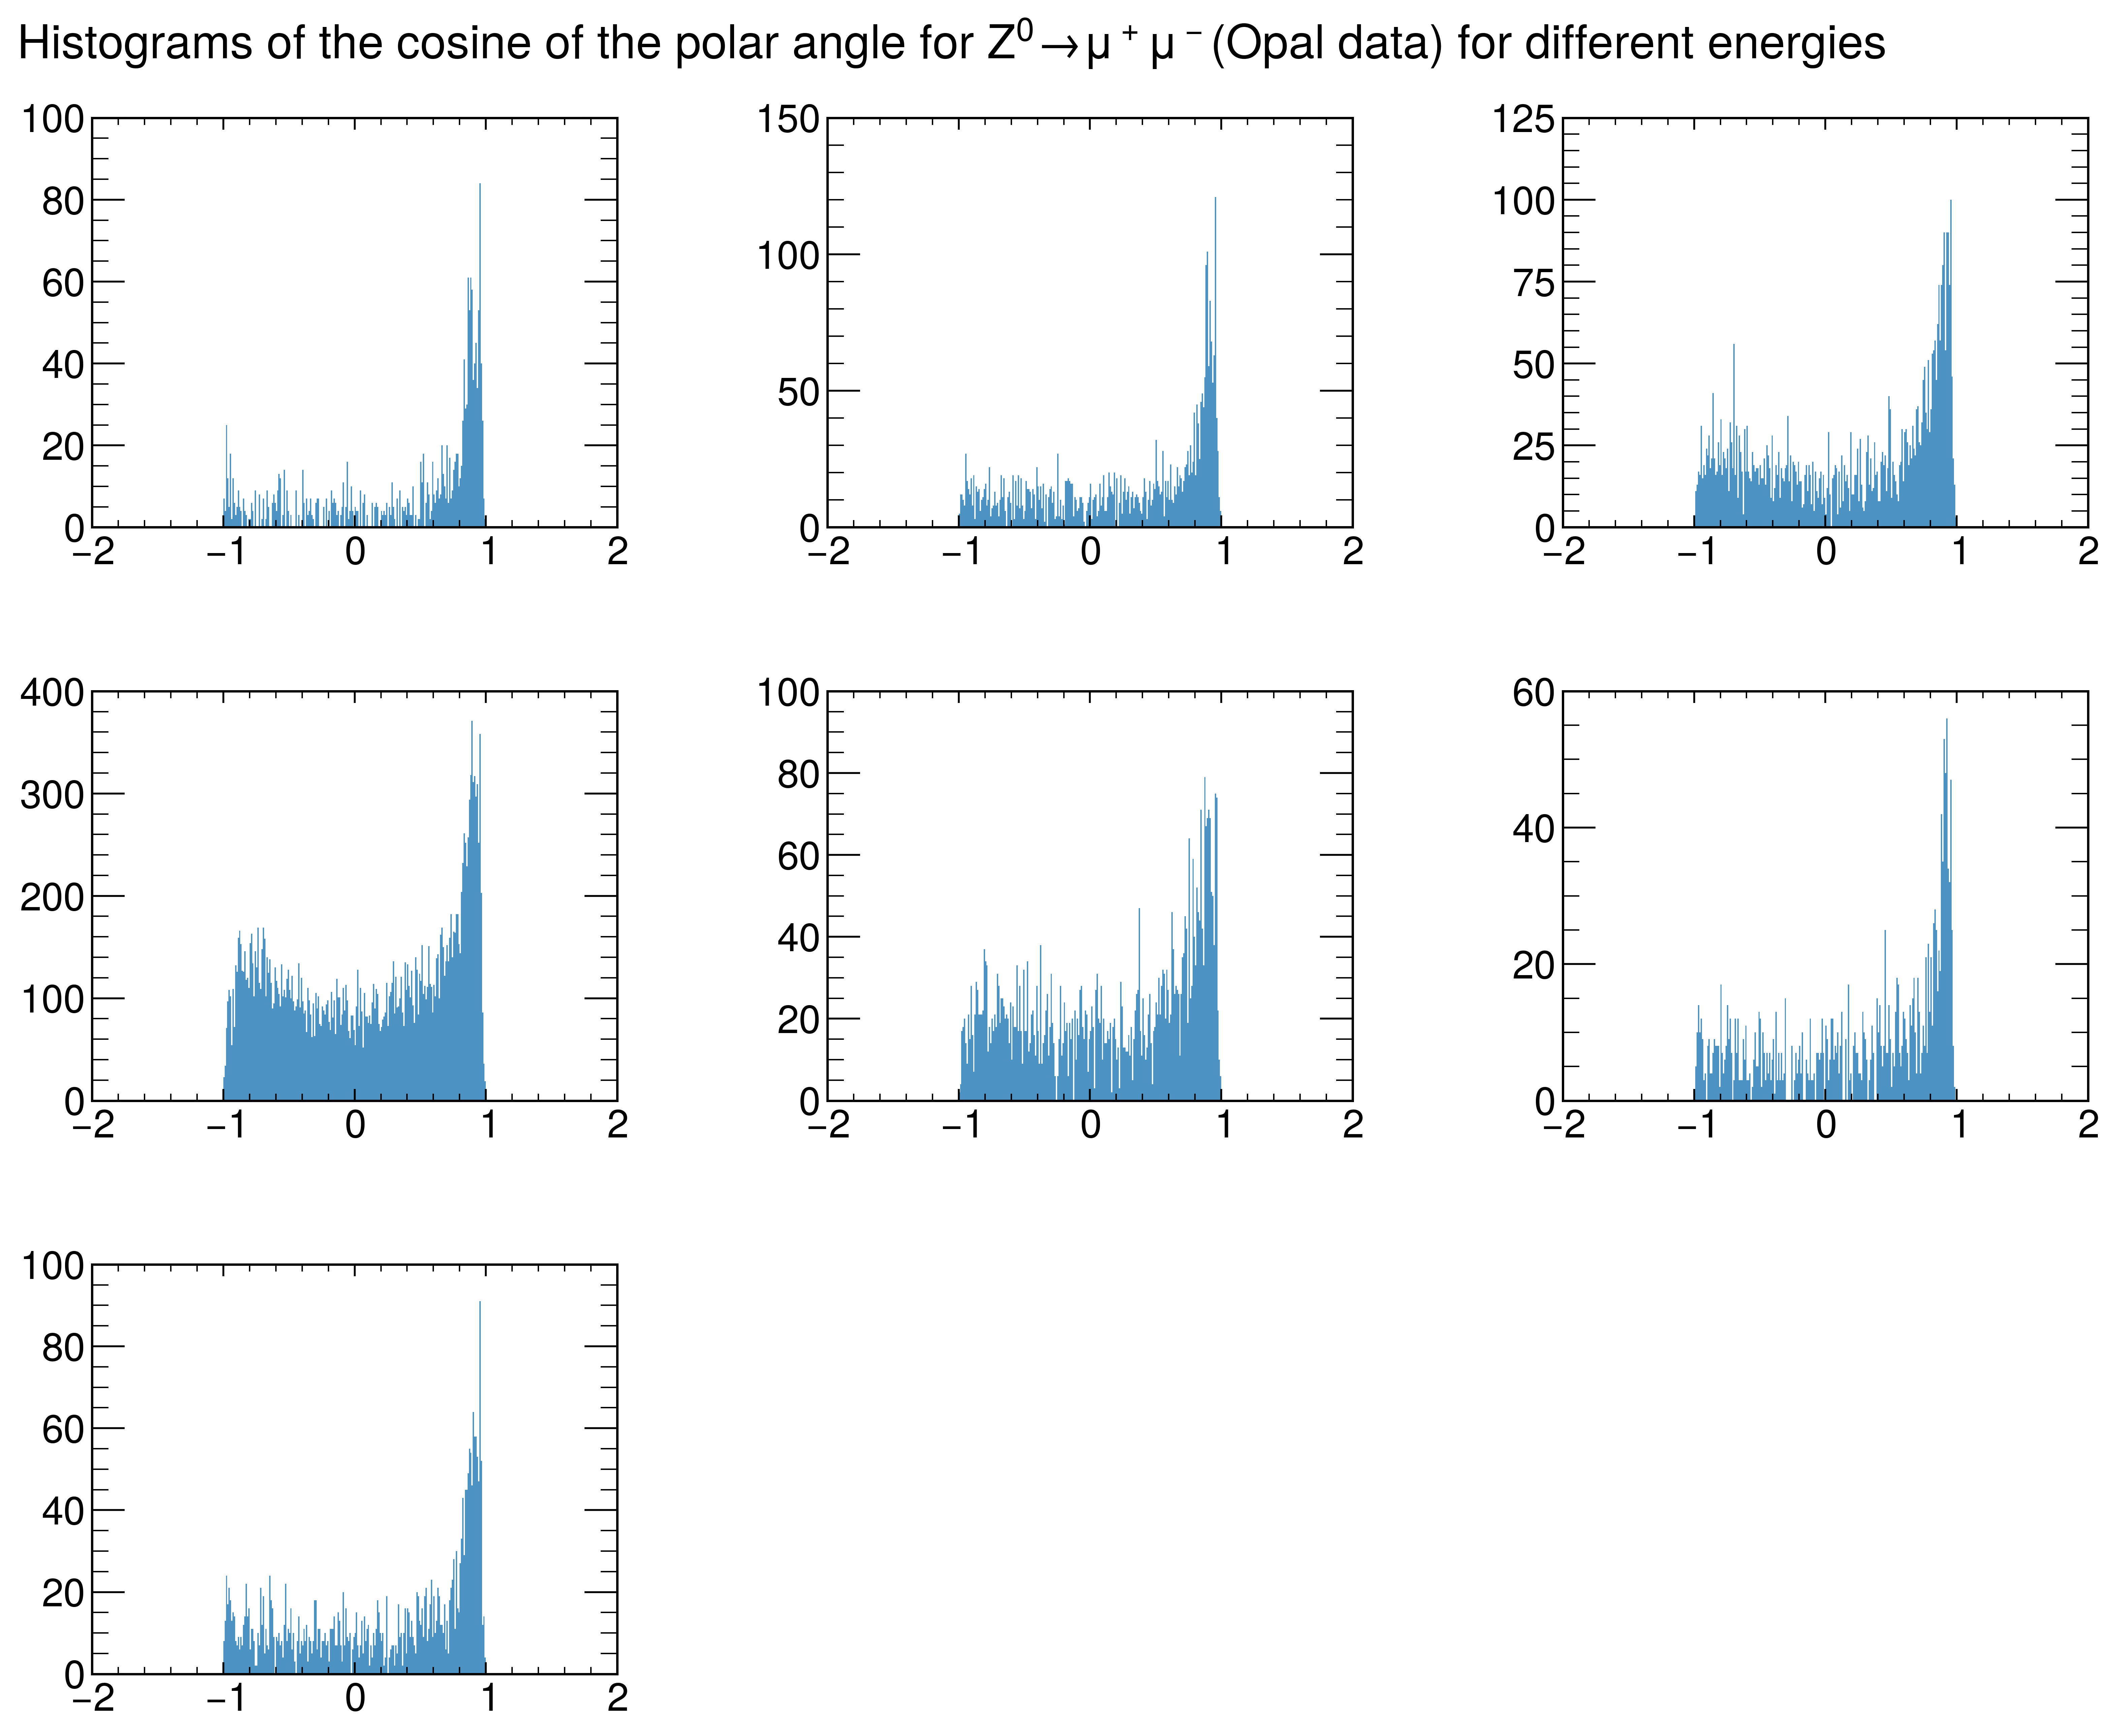

In [10]:
fig, ax = plt.subplots(figsize=(15, 12),dpi=500)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
fig.suptitle(r'Histograms of the cosine of the polar angle for $Z^0 \to \mu^+\mu^-$(Opal data) for different energies',fontsize=20)
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
i=0;

A_FB = []
A_FB_sigma = []
for energy, cm in cos_theta_muon.items():
    cos_thet_np = np.array(cm)
    ax = plt.subplot(331+i)
    hbins, hedges, _ = plt.hist(cos_thet_np,bins= 200, range=(-1,1),
         label=r'$\cos(\theta)$ for $e^+e^- \to \ \mu^+\mu^-$', alpha = 0.8)
    
    
    c=100;
    # count muons on left (backward) and right (forward) side
    counter_back = sum(hbins[:c]) 
    counter_forw = sum(hbins[c:]) 

    # calculate the forward-backward asymmetry factor
    a_FB = (counter_forw-counter_back)/(counter_forw+counter_back) +radiation_corrections['correction'][i]
    # error via error propagation
    a_FB_sigma= np.sqrt(counter_forw/(counter_forw+counter_back)**2+
                        ((counter_forw-counter_back)/(counter_forw+counter_back)**2)**2*counter_forw+
                        counter_back/(counter_forw+counter_back)**2+
                        ((counter_forw-counter_back)/(counter_forw+counter_back)**2)**2*counter_back)
    
    if i==3:
        sin_thet_sq=1/4*(1-np.sqrt(np.abs(a_FB)/3)) #approximation used since mean energy close to resonance energy
        sin_thet_sq_sigma=1/8/np.sqrt(np.abs(a_FB)/3)*1/3*np.sqrt(a_FB_sigma)
    
    A_FB.append(a_FB)
    A_FB_sigma.append(a_FB_sigma)
    
    i+=1;
    
plt.show()

In [11]:
A_FB = np.array(A_FB)
A_FB_sigma = np.array(A_FB_sigma)

print(f'sin^2(theta_W)=(%.2f \pm %.2f) ' % (sin_thet_sq,sin_thet_sq_sigma))

sin^2(theta_W)=(0.19 \pm 0.01) 


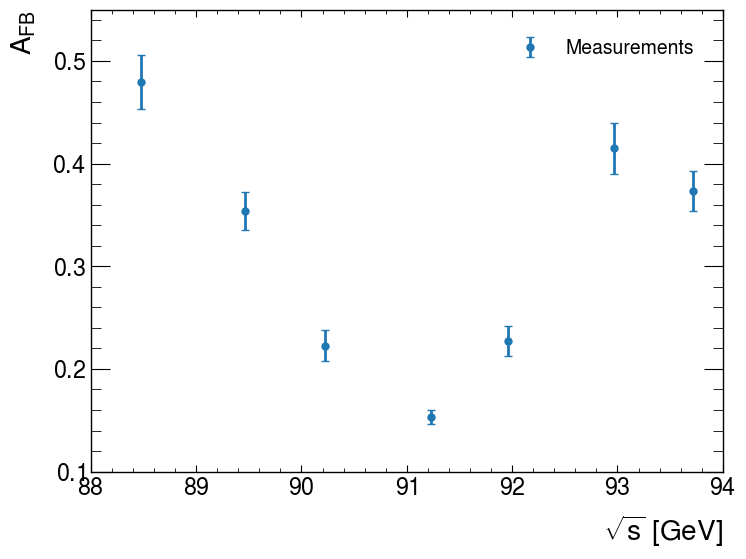

In [12]:
plt.errorbar(mean_energy_opal,A_FB,A_FB_sigma,marker='.',linestyle='None',label=r'Measurements',markersize=10,capsize=3, capthick=1)
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.ylabel(r'$A_{\rm{FB}}$')

# popt_lin, pcov_lin=curve_fit(lin, mean_energy,Asym_corr, sigma=dAsym, absolute_sigma=True)
plt.legend()
plt.show()